<link href="https://fonts.googleapis.com/css2?family=Barlow:wght@300&display=swap" rel="stylesheet">
<div style="font-family:'Barlow';font-size:18px;">
<h1>SmartPredict Test</h1> 
<blockquote>Author: Mahery Ranaivoson <br/> 
            Link: <a href="https://github.com/naivomah3/bank-deposit-analytics">Bank Deposit Analytics</a>
</blockquote>
</div>

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import math
import time
import matplotlib.pyplot as plt 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_context('talk')
sns.set_style('darkgrid', {'font.sans-serif': ['Iosevka']})

<link href="https://fonts.googleapis.com/css2?family=Barlow:wght@300&display=swap" rel="stylesheet">
<div style="font-family:'Barlow';font-size:22px;">
<h2>Bank term deposit subscription - Predictive Analytics</h2>
There has been a revenue decline for the Portuguese bank and they would like to know what actions to take. After investigation, we found out that the root cause is that their clients are not depositing as frequently as before. Knowing that term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can invest in higher gain financial products to make a profit. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues. As a result, the Portuguese bank would like to identify existing clients that have higher chance to subscribe for a term deposit and focus marketing effort on such clients.

Source: <a href="https://www.kaggle.com/benroshan/bank-marketing-campaign-predictive-analytics">Bank marketing campaign | Predictive analytics</a>
    
<h3>Problem Statement</h3>
This is a binary classification problem where there two classes includes: 
    <li><b>yes:</b> denoting that the customer subscribed to a term deposit</li>
    <li><b>no:</b> denoting that the customer did not subscribe.</li>
</div>

<link href="https://fonts.googleapis.com/css2?family=Barlow:wght@300&display=swap" rel="stylesheet">
<div style="font-family:'Barlow';font-size:22px;">
<h2>1. Exploratory Data Analysis</h2>
</div>

In [4]:
file = 'datasets/bank-full.csv'

In [5]:
def load_dataset(filename, na_val=None, verbose=False):
    df = pd.read_csv(filename, na_values=na_val, sep=';')
    # Features and Target column name 
    features = df.columns

    print("+ Dataset:")
    display(df.head(3))
    
    if verbose:
        print("+ Shape:")
        display(df.shape) 
        print("")
        print(f"+ Statistics Summary: ")
        display(df.describe())
    
    return features, df

features, dataset = load_dataset(file, na_val=None, verbose=True)


+ Dataset:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


+ Shape:


(45211, 17)


+ Statistics Summary: 


,age,balance,day,duration,campaign,pdays,previous
count,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000
mean,40.9362,1362.2721,15.8064,258.1631,2.7638,40.1978,0.5803
std,10.6188,3044.7658,8.3225,257.5278,3.0980,100.1287,2.3034
min,18.0000,-8019.0000,1.0000,0.0000,1.0000,-1.0000,0.0000
25%,33.0000,72.0000,8.0000,103.0000,1.0000,-1.0000,0.0000
50%,39.0000,448.0000,16.0000,180.0000,2.0000,-1.0000,0.0000
75%,48.0000,1428.0000,21.0000,319.0000,3.0000,-1.0000,0.0000
max,95.0000,102127.0000,31.0000,4918.0000,63.0000,871.0000,275.0000


### 1.1. Target Distribution
The target variable `y` is the customer decision after conducting a phone call campaign whether or not they had placed a term deposit. <br>
#### + Observations 
The proportion shows a high rate of class imbalanced of the target variable which needs to be addressed in the upcoming analysis.

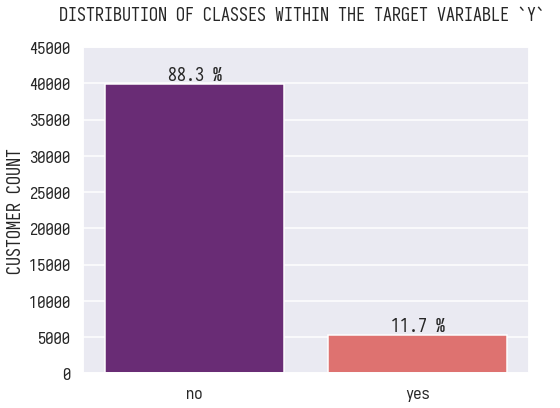

In [6]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="y", data=dataset, palette='magma')

total = float(len(dataset))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 500, f'{(height/total) * 100:.1f} %', ha = "center") 

plt.ylim([0, 45_000]) 
plt.title('Distribution of classes within the target variable `Y` \n'.upper(), fontsize=18)
plt.xlabel(''.upper(), fontsize=18)
plt.ylabel('Customer count'.upper())
plt.show();

### 1.2. Categorical features distribution across the target variable 
#### + Observations 
- In the following report, we are increasing the level of detail to clearly show the proportion of customers had agreed to place deposit or not. 

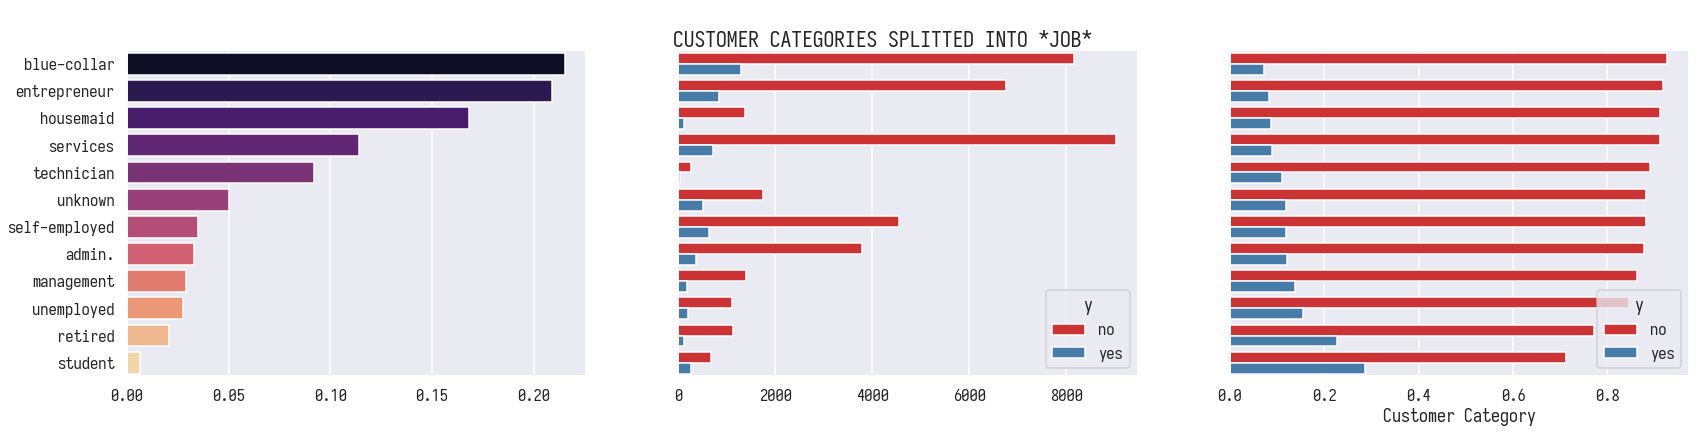

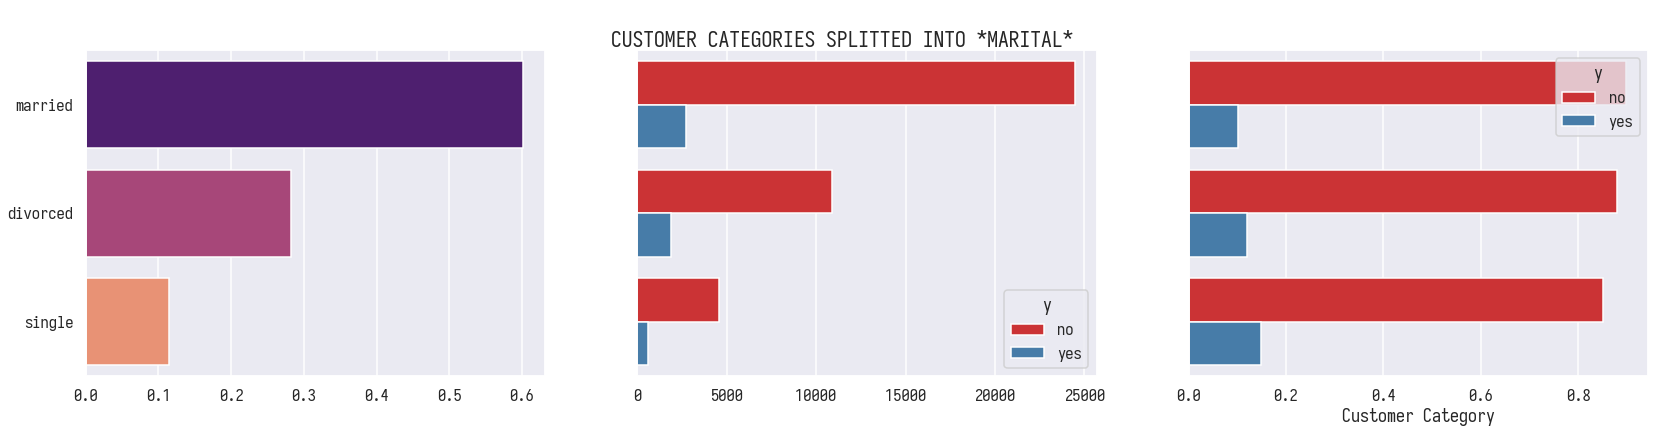

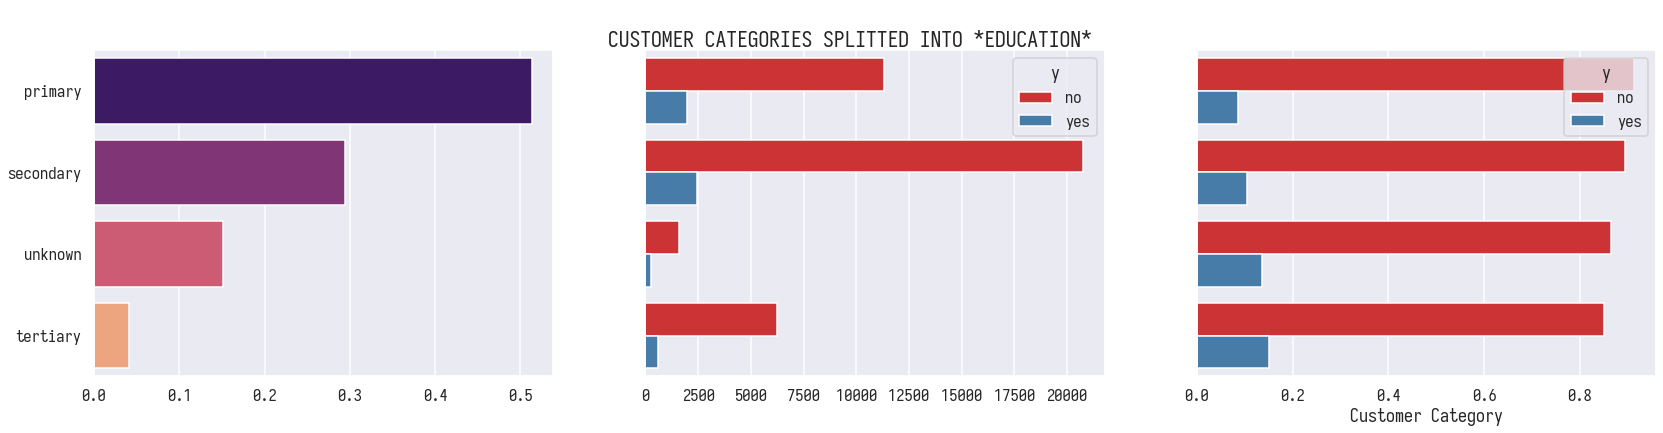

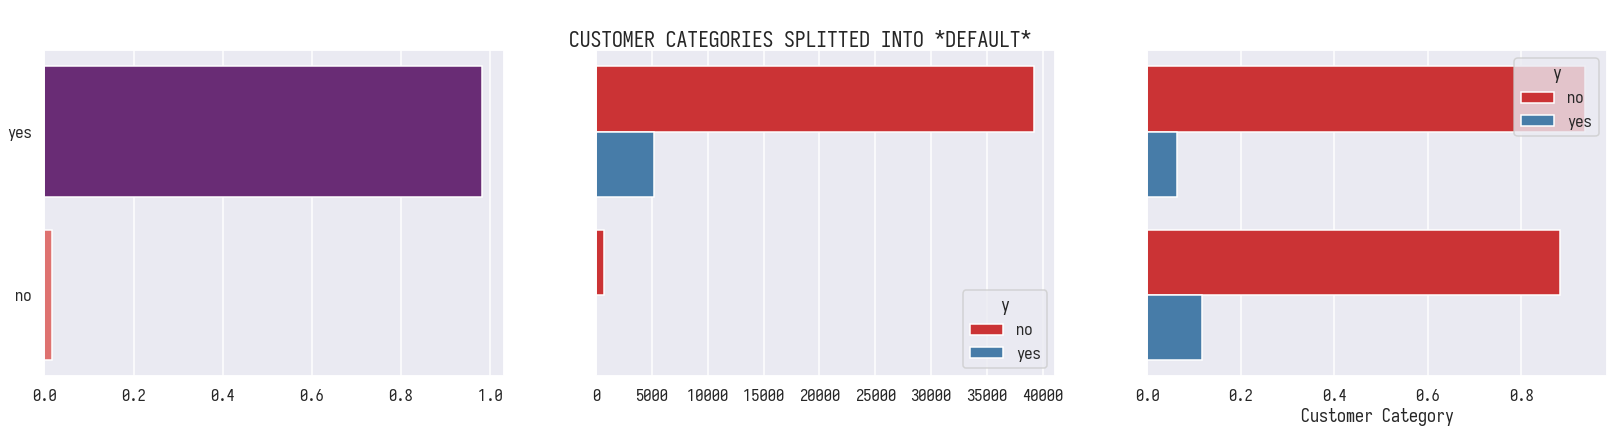

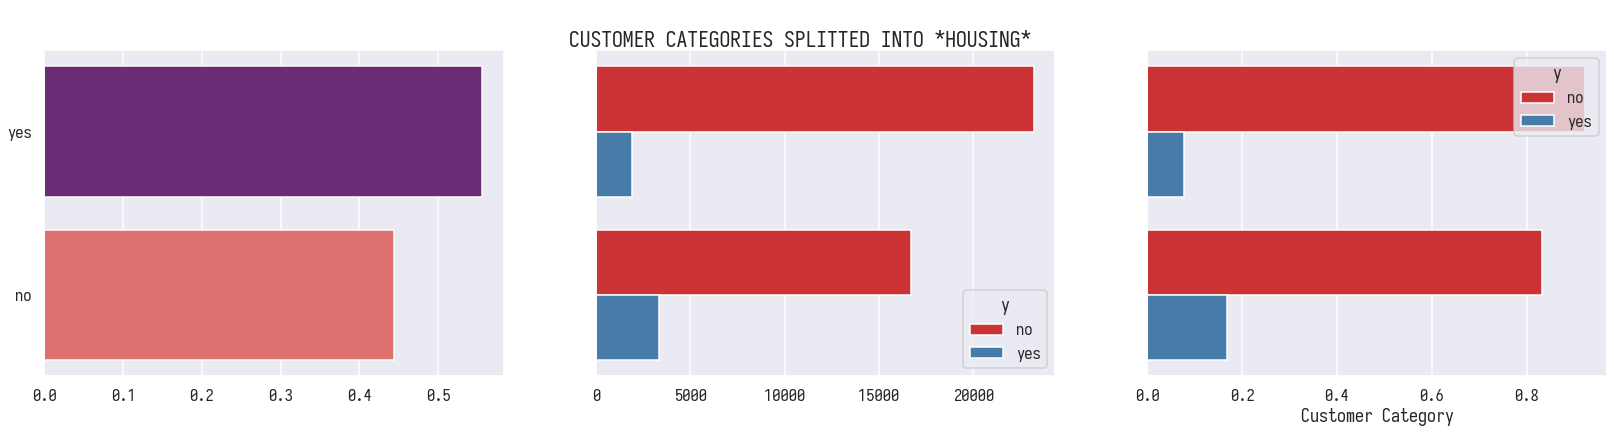

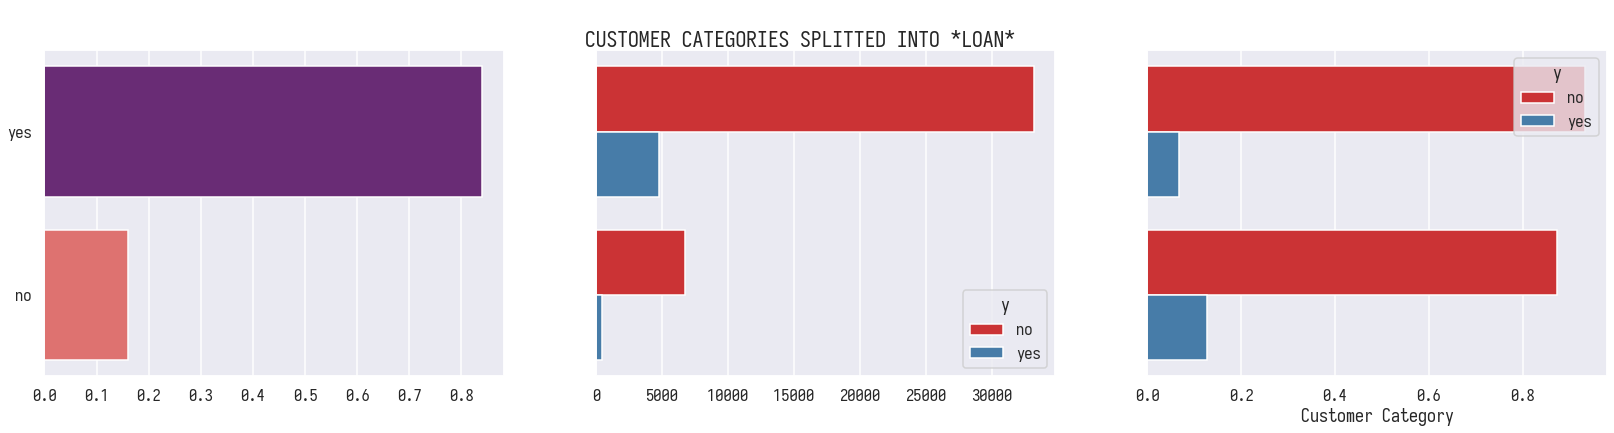

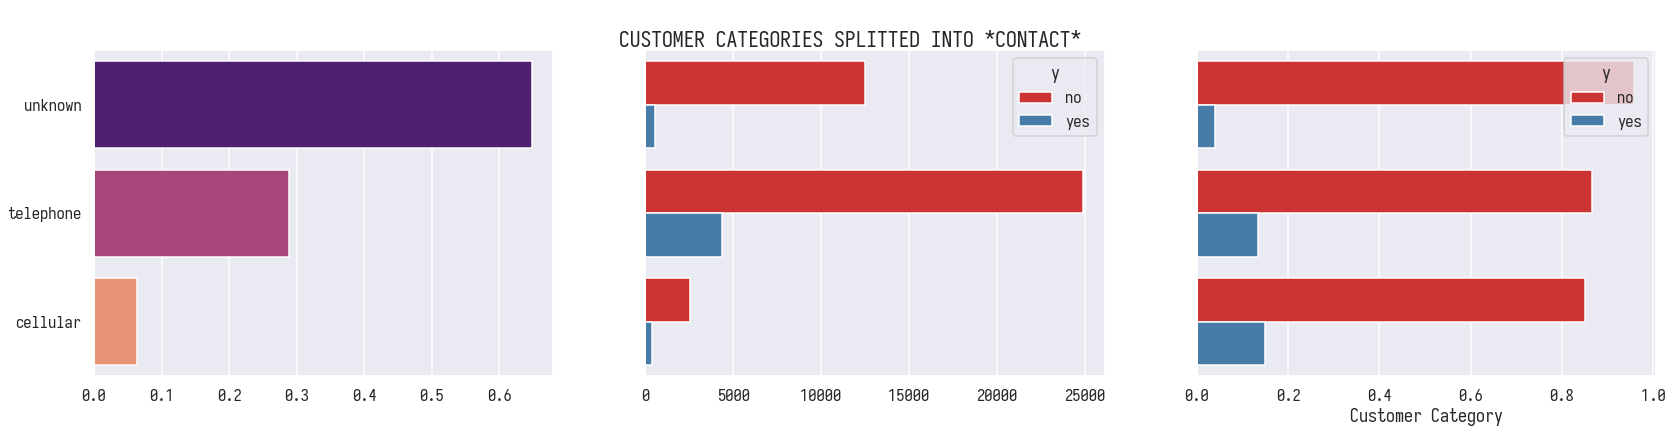

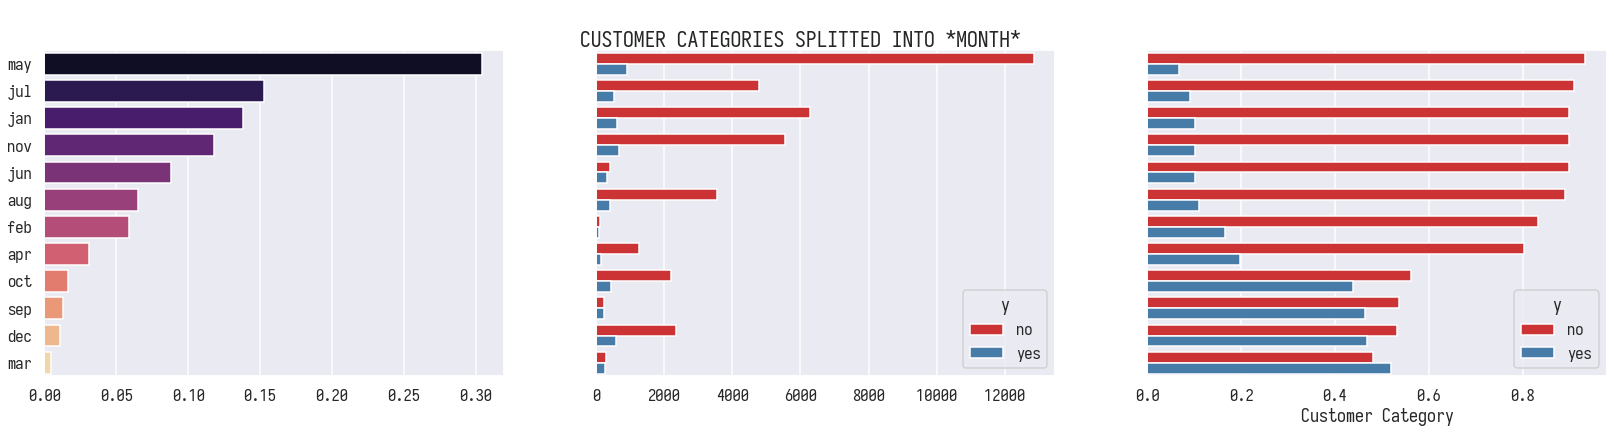

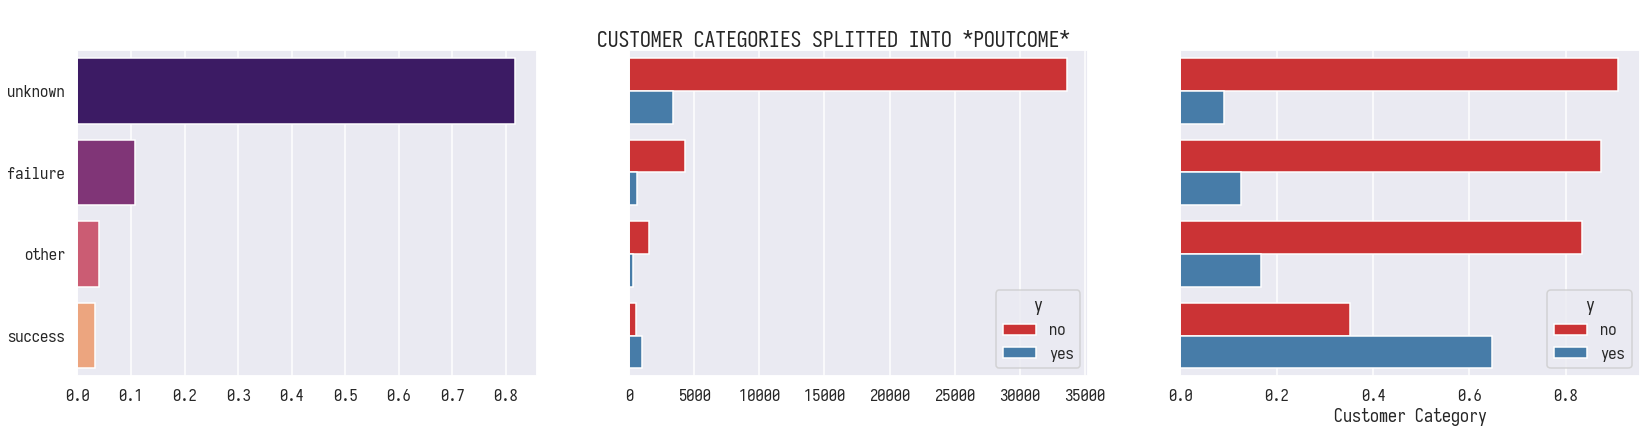

In [7]:
def vis_cat_feat_dist(col):
    fig, ax = plt.subplots(1, 3, figsize=(28, 6), sharey=True)
    
    df = dataset[col].value_counts(normalize=True).reset_index()
    df.sort_values(by=col,ascending=False, inplace=True)
    count_plot = sns.barplot(ax=ax[0], y='index', x=col, data=df, palette='magma')
    _ = ax[0].set_xlabel('')
    _ = ax[0].set_ylabel('')
    
    # Plot target distribution acrross features with the proportion in details  
    count_plot = sns.countplot(ax=ax[1], y=col, hue='y', data=dataset, palette='Set1')
    _ = ax[1].set_xlabel('')
    _ = ax[1].set_ylabel('')
    
    # Plot target distribution accross features with the proportion in details  
    df = pd.DataFrame(dataset.groupby(col)["y"].value_counts(normalize=True)).unstack(1).unstack(1).reset_index()
    df.rename(columns={0:'No_Proportion'}, inplace=True)
    df.sort_values(by='No_Proportion', ascending=False, inplace=True)
    count_plot = sns.barplot(ax=ax[2], y=col, x='No_Proportion', hue='y', data=df, palette='Set1')
    _ = ax[2].set_xlabel('Customer Category')
    _ = ax[2].set_ylabel('')
    
    fig.suptitle(f'\nCustomer categories splitted into *{col}*'.upper(), fontdict={'size': 18})
    plt.show()

    
cols = dataset.select_dtypes(include=['object']).drop("y", axis=1).columns
for col in cols:
    vis_cat_feat_dist(col)
    

### 1.3. Numerical features distribution across the target variable 
#### + Observations 
- Only the `age` factor is almost normally distributed, `day`, `balance`, `duration`, `campaign`, `pdays` are heavy-tailed with the presence of high amount of outlier. In both cases, several transformations may be required


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


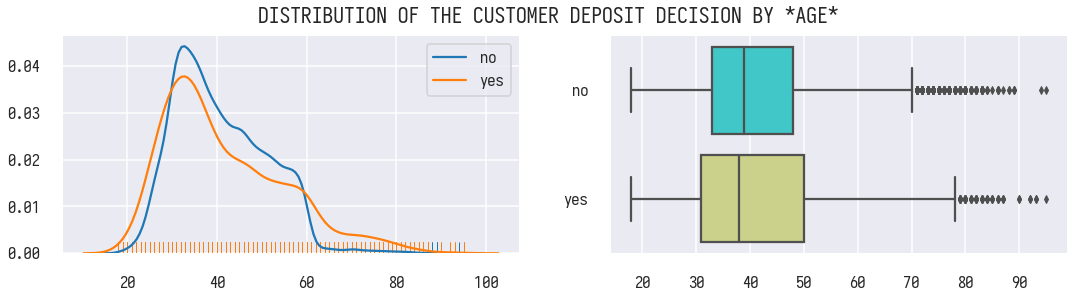

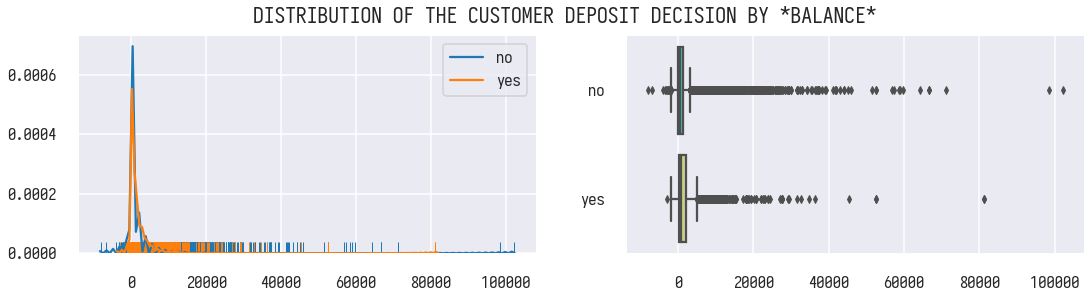

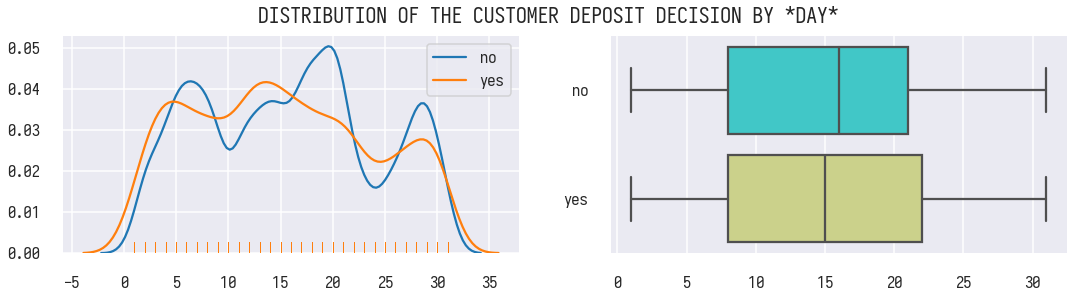

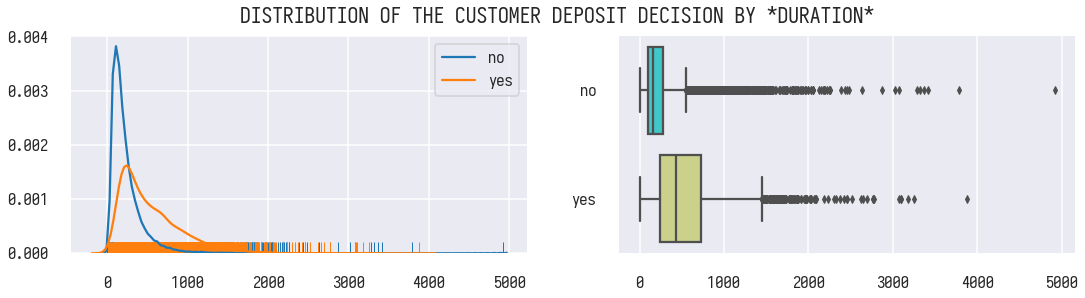

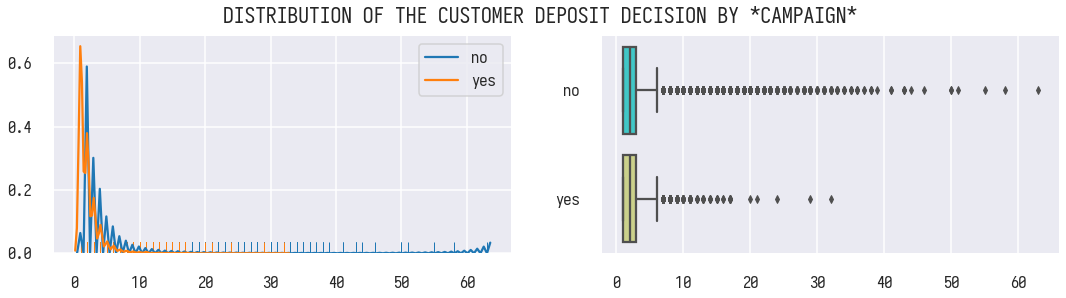

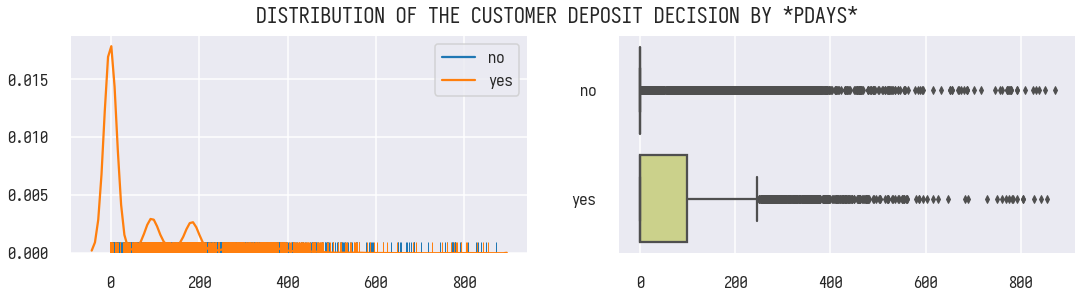

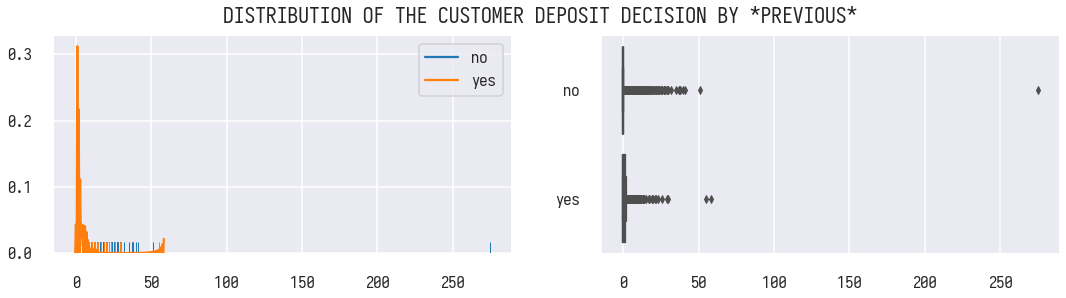

In [9]:
def vis_cat_num_dist(col):
    fig, ax = plt.subplots(1, 2, figsize=(18, 4),)
    
    labels = dataset["y"].unique()  
    targets = [dataset.loc[dataset["y"] == label] for label in labels]
    # Iterate through list and plot the sliced dataframe
    for (target, label) in zip(targets, labels):
        sns.distplot(target[col], ax=ax[0], hist=False, label=label, kde=True, rug=True)
        
    _ = ax[0].set_xlabel('')
    _ = ax[0].set_ylabel('')
    
    # Boxplot for each category 
    sns.boxplot(ax=ax[1], x=col, y='y', data=dataset, palette='rainbow',)
    sns.despine(offset=10, trim=True)
    _ = ax[1].set_xlabel('')
    _ = ax[1].set_ylabel('')
    
    fig.suptitle(f'Distribution of the customer deposit decision by *{col}*'.upper(), fontdict={'size': 17})
    plt.show()
    
cols = dataset.select_dtypes(include=['number']).columns
for col in cols:
    vis_cat_num_dist(col)

### 1.4. Features correlation
#### + Observations 
- There is no significant correlation among the numerical features


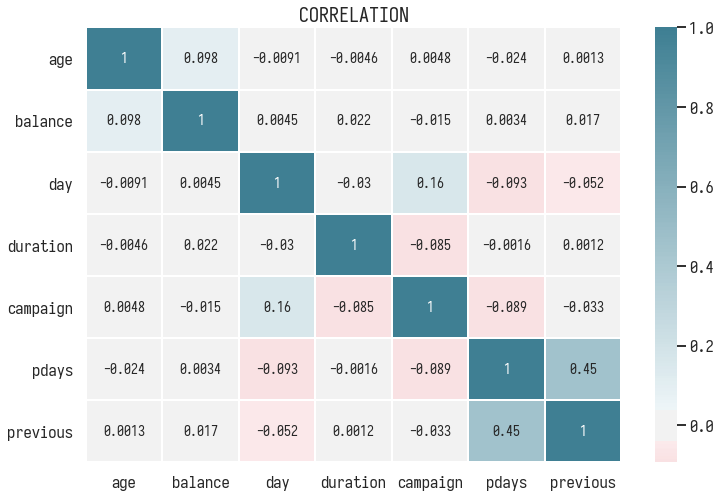

In [10]:
def visualize_corr_mat(features):
    corr = dataset[features].corr()
    plt.figure(figsize = (12,8))
    cmap = sns.diverging_palette(10, 220, as_cmap = True)
    cbar_kws = {'orientation': 'vertical', 
                'extendfrac': 0.1, }
    annot_kws={'fontsize':14} 
    sns.heatmap(corr, 
                center = 0, 
                cmap = cmap,
                annot = True, 
                annot_kws = annot_kws,  
                linewidths = 1, 
                cbar_kws = cbar_kws);
    plt.title('Correlation'.upper(), fontsize=20)
    plt.show();   
    
# Plot correlation 
cols = dataset.select_dtypes(include=['number']).columns
visualize_corr_mat(features)

In [278]:
import re
import pickle
import joblib
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder, RareLabelCategoricalEncoder
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm
from scipy import stats

## 2. Feature Engineering

As baseline feature engineering, we are considering the following transformation:

**Binary and Ordinal Encoding:** education, default, housing, loan, poutcome, previous, y <br>
**Rare Category Grouping:** job, contact, month <br>
**WoE Encoding:** contact, month <br>
**OneHotEncoding:** job, marital <br>
**Yeo-Johnson Transformation:** age, day, balance, duration, campaign, pdays, 


### 2.1. Categorical feature encoding 

In [12]:
dataset.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


#### + Ordinal and Binary Encoder - basic categorical feature encoding

- Some categories can be directly encoded without any further assumption as some features hold only Yes/No categories that could be binary-encoded and whose that could be ranked will be encoded in order according to the natural/logicical ranking.

In [13]:
def ord_bin_enc(df):
    df["education"] = dataset["education"].map({'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': -1,}).astype('int8') 
    df["default"] = dataset["default"].apply(lambda x: 1 if x == 'no' else 0).astype('uint8')
    df["housing"] = dataset["housing"].apply(lambda x: 1 if x == 'yes' else 0).astype('uint8')
    df["loan"] = dataset["loan"].apply(lambda x: 1 if x == 'yes' else 0).astype('uint8')
    df["poutcome"] = dataset["poutcome"].apply(lambda x: 1 if x == 'success' else 0).astype('uint8')
    df["previous"] = dataset["previous"].apply(lambda x: x if x == 0 else 1).astype('uint8')
    df["y"] = dataset["y"].apply(lambda x: 1 if x == 'yes' else 0).astype('uint8')
    return df
dataset_enc = ord_bin_enc(dataset)

In [14]:
dataset_enc.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,3,1,2143,1,0,unknown,5,may,261,1,-1,0,0,0
1,44,technician,single,2,1,29,1,0,unknown,5,may,151,1,-1,0,0,0
2,33,entrepreneur,married,2,1,2,1,1,unknown,5,may,76,1,-1,0,0,0


#### + Split the data into train and test set 

- To avoid data leakeage, we are applying all the feature engineering computation onto the train set, and then use the result mappings in the test set using **Pipeline**. For that, we will use StratifiedShuffleSplit to split the data while taking into consideration that the same ratio on the target column must be kept in both training and testing set.

In [15]:
st = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X = dataset_enc.drop(['y'], axis=1)
y = dataset_enc["y"]
for train, test in st.split(X, y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

# almost same ratio
print('\nratio of target in y_train :', y_train.value_counts().values/ len(y_train))
print('ratio of target in y_test :', y_test.value_counts().values/ len(y_test))
print('ratio of target in original_data :', dataset_enc["y"].value_counts().values/ len(dataset_enc))


X_train shape (36168, 16)
y_train shape (36168,)
X_test shape (9043, 16)
y_test shape (9043,)

ratio of target in y_train : [0.88301814 0.11698186]
ratio of target in y_test : [0.88300343 0.11699657]
ratio of target in original_data : [0.8830152 0.1169848]


#### + Rare category grouping - applied on categorical variables

- Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare. It is hard to derive reliable information from very infrequent categories they tend to appear only on train set or only on the test set. 

In the following approach, we can group infrequent labels or categories under a new category called 'Rare' or 'Other'. However, it is to be noted that: 
- Grouping categories into rare for variables that show low cardinality may or may not improve model performance, however, we tend to re-group them into a new category to smooth model deployment.
- Grouping categories into rare for variables with high cardinality, tends to improve model performance as well.

In [16]:
# Filtering rare categories using graph  
def vis_rare_cat(data, col):
    df = pd.Series(data[col].value_counts() / len(data))
    # make plot with the above percentages
    _ = plt.figure(figsize = (10,4))
    fig = df.sort_values(ascending=False).plot.bar()
    _ = fig.set_xlabel(col)
    # add a line at 5 % to flag the threshold for rare categories
    _ = fig.axhline(y=0.05, color='red')
    _ = fig.set_xlabel(f"{col}".upper())
    _ = fig.set_ylabel('Category percentage'.upper())
    plt.show()

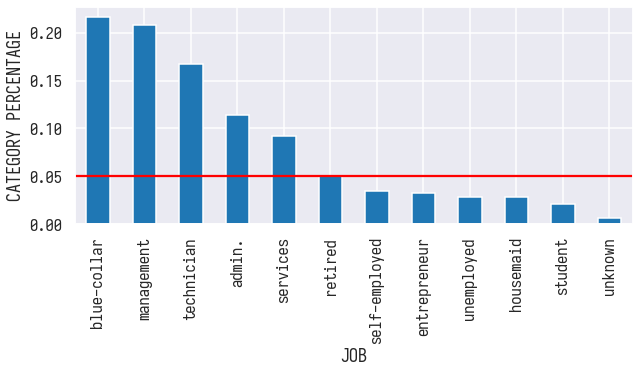

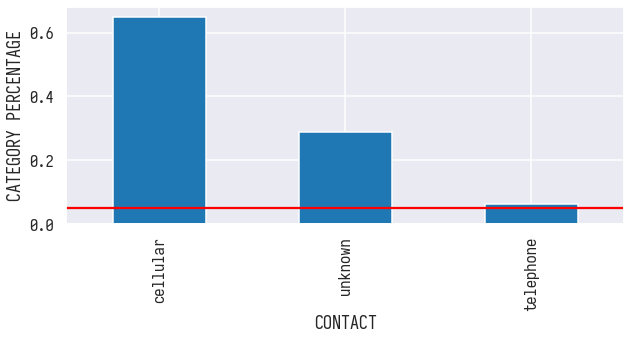

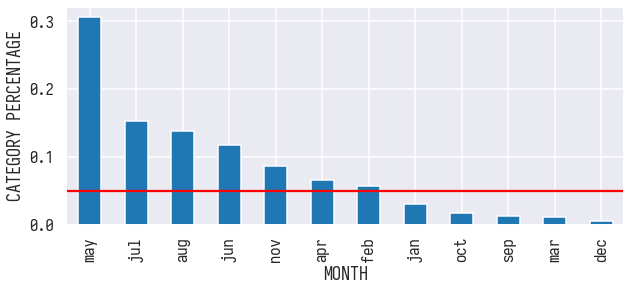

In [17]:
for col in ['job', 'contact', 'month']:
    vis_rare_cat(X_train, col)

In [18]:
# Figure out and group rare categories 
def rare_encoding(cols, n_cat=4, X_train=None, X_fit=None, encoder=None, tolerance=0.05):
    # If need to fit
    if not encoder:
        rare_enc = RareLabelCategoricalEncoder(
            tol=tolerance,  # minimal percentage to be considered non-rare
            n_categories=n_cat, # minimal number of categories the variable should have to re-cgroup rare categories
            variables=cols # variables to re-group
        )
        rare_enc.fit(X_train)
        return rare_enc.transform(X_fit), rare_enc
    else: 
        return encoder.transform(X_fit)
    

In [ ]:
cols = ['job', 'contact', 'month']
X_train_rare, rare_encoder = rare_encoding(cols, X_train=X_train, X_fit=X_train)
X_test_rare = rare_encoding(cols, encoder=rare_encoder, X_fit=X_test)

In [250]:
# Persist Encoder 
def persist_rare_encoder():
    handler = open("flask-api/objects/rare_encoder.obj","wb")
    pickle.dump(rare_encoder, handler)
    handler.close()
# persist_rare_encoder()

#### + Weight of Evidence Encoder - advanced categorical feature encoding 

The WoE transformation has three advantages: <br>
- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:<br>
- Prone to cause over-fitting

Reference: [here](http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview)

In [20]:
# Rare categories grouping 
def woe_encoding(cols, X_train=None, y_train=None, X_fit=None, encoder=None):
    # If need to fit
    if not encoder:
        woe_enc = WoERatioCategoricalEncoder(
            encoding_method = 'woe',
            variables=cols)
        woe_enc.fit(X_train, y_train)
        return woe_enc.transform(X_fit), woe_enc
    else: 
        return encoder.transform(X_fit)

In [21]:
cols = ['contact', 'month']
X_train_enc, woe_encoder = woe_encoding(cols, X_train=X_train_rare, y_train=y_train, X_fit=X_train_rare)
X_test_enc = woe_encoding(cols, encoder=woe_encoder, X_fit=X_test_rare)

In [252]:
# Persist Encoder 
def persist_woe_encoder():
    handler = open("flask-api/objects/woe_encoder.obj","wb")
    pickle.dump(woe_encoder, handler)
    handler.close()
# persist_woe_encoder()

In [22]:
X_train_enc.head(3)
X_train_enc.shape

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
24001,36,technician,divorced,2,1,861,0,0,0.2011,29,-0.0765,140,2,-1,0,0
43409,24,Rare,single,2,1,4126,0,0,0.2737,5,0.6066,907,4,185,1,0
20669,44,technician,single,2,1,244,1,0,0.2737,12,-0.0765,1735,4,-1,0,0


(36168, 16)

#### + OneHot Encoder - advanced categorical feature encoding 

In [23]:
# One hot encode categorical variable 
def ohe_encoding(cols, n_cat=4, X_train=None, X_fit=None, encoder=None):
    # If need to fit
    if not encoder:
        ohe_enc = OneHotEncoder(sparse=False)
        ohe_enc.fit(X_train[cols])
        X_enc = pd.DataFrame(ohe_enc.transform(X_fit[cols]), columns=ohe_enc.get_feature_names()).reset_index(drop=True)
        X_fit = X_fit.drop(cols, axis=1).reset_index(drop=True)
        X_fit = X_fit.merge(X_enc, left_index=True, right_index=True)
        return X_fit, ohe_enc
    else: 
        X_enc = pd.DataFrame(encoder.transform(X_fit[cols]), columns=encoder.get_feature_names()).reset_index(drop=True)
        X_fit = X_fit.drop(cols, axis=1).reset_index(drop=True)
        X_fit = X_fit.merge(X_enc, left_index=True, right_index=True)
        return X_fit

In [24]:
cols = ['job', 'marital']
X_train_enc, ohe_encoder = ohe_encoding(cols, X_train=X_train_enc, X_fit=X_train_enc)
X_test_enc = ohe_encoding(cols, encoder=ohe_encoder, X_fit=X_test_enc)

In [254]:
# Persist Encoder 
def persist_ohe_encoder():
    handler = open("flask-api/objects/ohe_encoder.obj","wb")
    pickle.dump(ohe_encoder, handler)
    handler.close()
# persist_ohe_encoder()

In [25]:
X_train_enc.head(3)
X_train_enc.shape

,age,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,x0_Rare,x0_admin.,x0_blue-collar,x0_management,x0_retired,x0_services,x0_technician,x1_divorced,x1_married,x1_single
0,36,2,1,861,0,0,0.2011,29,-0.0765,140,2,-1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
1,24,2,1,4126,0,0,0.2737,5,0.6066,907,4,185,1,0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,44,2,1,244,1,0,0.2737,12,-0.0765,1735,4,-1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000


(36168, 24)

### 2.2. Numerical feature transformation

#### + Yeo-Johnson transformation - applied on numerical variables 

As shown at `1.3`, the numeric variables `day`, `balance`, `duration`, `campaign`, `pdays` are all right-skewed which clearly indicates that they are not normal. The `Yeo-Johnson` transformation is a family of power transform functions that are used to stabilize variance for the data to be normal, or at most near normal. 

Reference: [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)

In [26]:
def plot_dist(df, feature, title, transformer):
    val_bf_log = df.loc[:, feature]
    val_af_log = transformer.fit_transform(df[[feature]]).flatten()
    
    # Grid plot:
    fig = plt.figure(constrained_layout=True, figsize=(20, 8))
    grid = gridspec.GridSpec(ncols=7, nrows=4, figure=fig, hspace=0.8, wspace=0)
    
    # Histograms:
    hist_ax_before = fig.add_subplot(grid[:2, :2])
    sns.distplot(val_bf_log, hist=True, kde=True, fit=norm, ax=hist_ax_before, color='#e74c3c')
    hist_ax_before.legend(labels=['Normal', 'Actual'])
    hist_ax_before.set_title('')
    hist_ax_before.set_xlabel(feature)
    hist_ax_before.set_ylabel('DENSITY ESTIM.')
    
    hist_ax_after = fig.add_subplot(grid[:2, 4:6])
    sns.distplot(val_af_log, hist=True, kde=True, fit=norm, ax=hist_ax_after, color='#e74c3c')
    hist_ax_after.legend(labels=['Normal', 'Actual'])
    hist_ax_after.set_title('')
    hist_ax_after.set_xlabel(feature)
    hist_ax_after.set_ylabel('DENSITY ESTIM.')
    

    # QQ_plots:
    qq_ax_before = fig.add_subplot(grid[2:3, :2])
    stats.probplot(val_bf_log, plot=qq_ax_before)
    qq_ax_before.get_lines()[0].set_markerfacecolor('#e74c3c')
    qq_ax_before.get_lines()[0].set_markersize(12.0)
    qq_ax_before.set_title('')
    qq_ax_before.set_xlabel('THEORETICAL QUANTILES')
    qq_ax_before.set_ylabel(feature)
    
    qq_ax_after = fig.add_subplot(grid[2:3, 4:6])
    stats.probplot(val_af_log, plot=qq_ax_after)
    qq_ax_after.get_lines()[0].set_markerfacecolor('#e74c3c')
    qq_ax_after.get_lines()[0].set_markersize(12.0)
    qq_ax_after.set_title('')
    qq_ax_after.set_xlabel('THEORETICAL QUANTILES')
    qq_ax_after.set_ylabel(feature)
    
    
    # Box Plots:
    bx_ax_before = fig.add_subplot(grid[:3, 2])
    sns.boxplot(val_bf_log, orient='v', ax=bx_ax_before, color='#e74c3c')
    bx_ax_before.set_title('')
    bx_ax_before.set_ylabel(feature)
    bx_ax_before.set_xlabel('')
    bx_ax_before.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    bx_ax_after = fig.add_subplot(grid[:3, 6])
    sns.boxplot(val_af_log, orient='v', ax=bx_ax_after, color='#e74c3c')
    bx_ax_after.set_title('')
    bx_ax_after.set_ylabel(feature)
    bx_ax_after.set_xlabel('')
    bx_ax_after.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    plt.suptitle(f'{title}', fontsize=20)

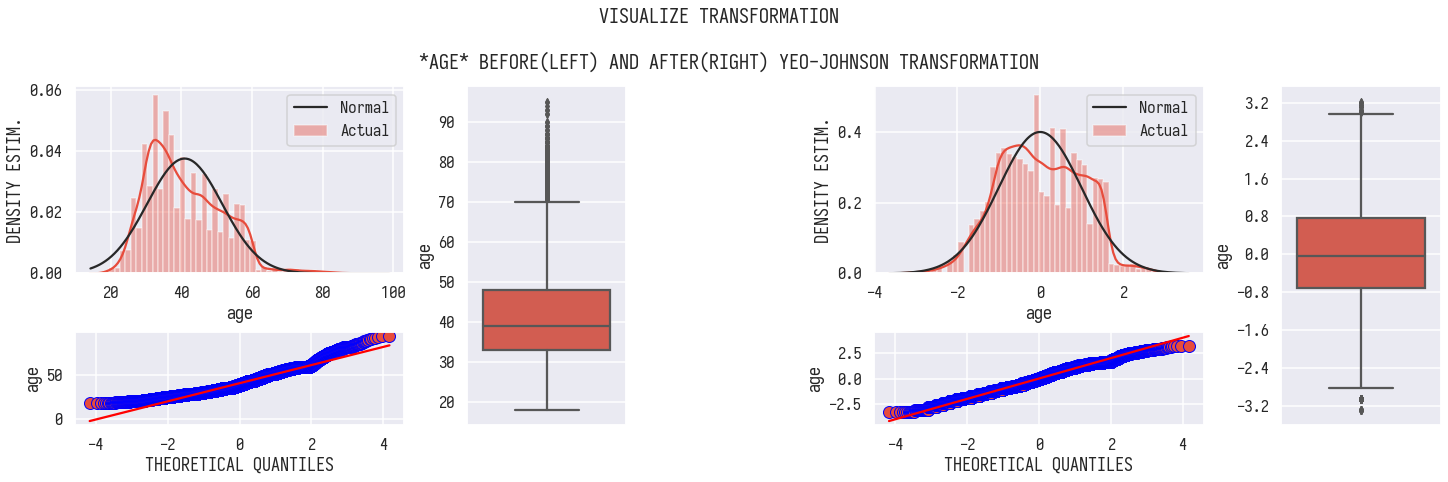

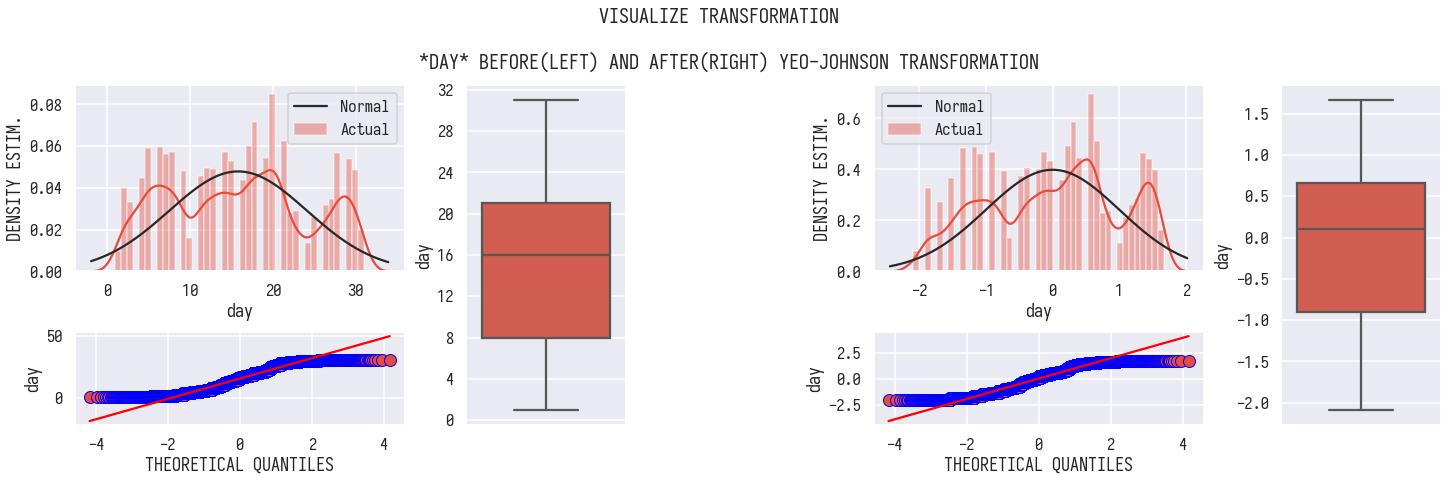

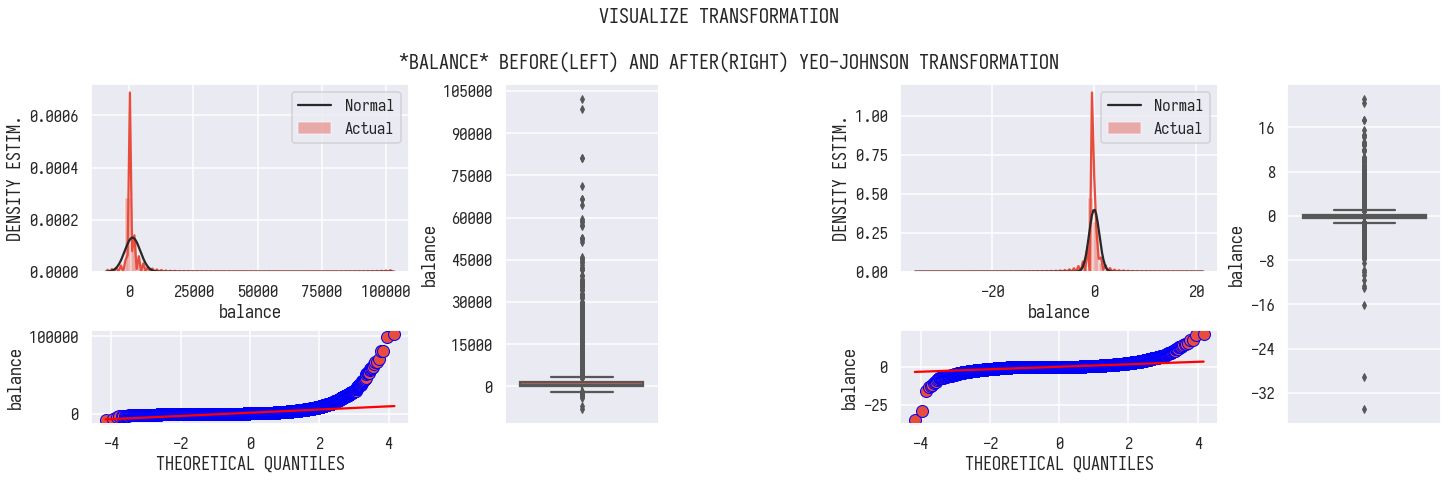

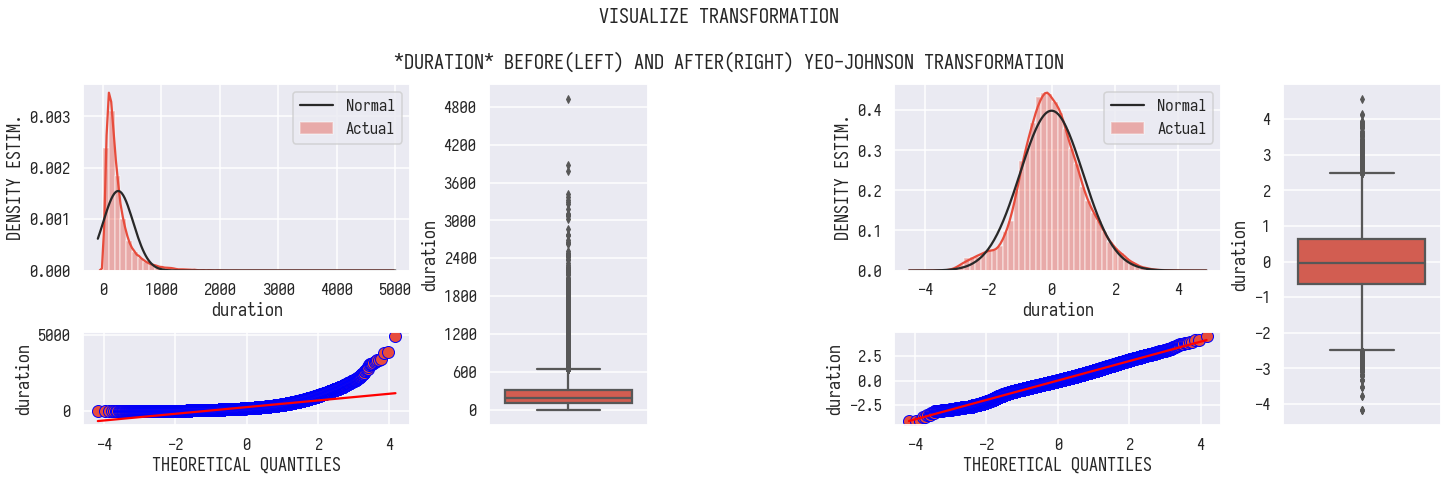

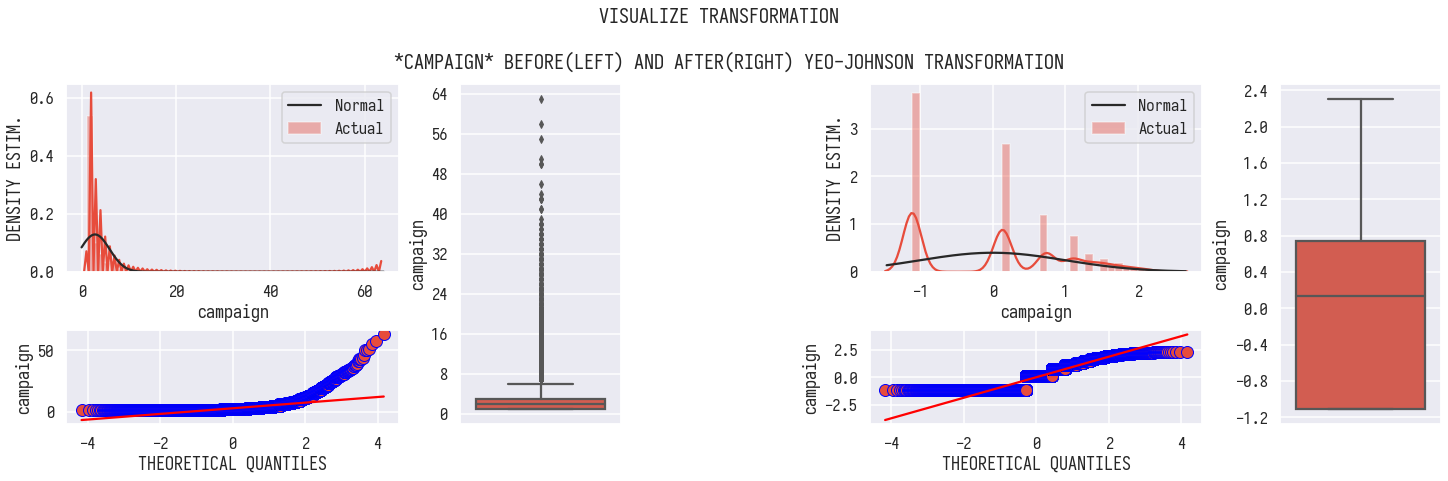

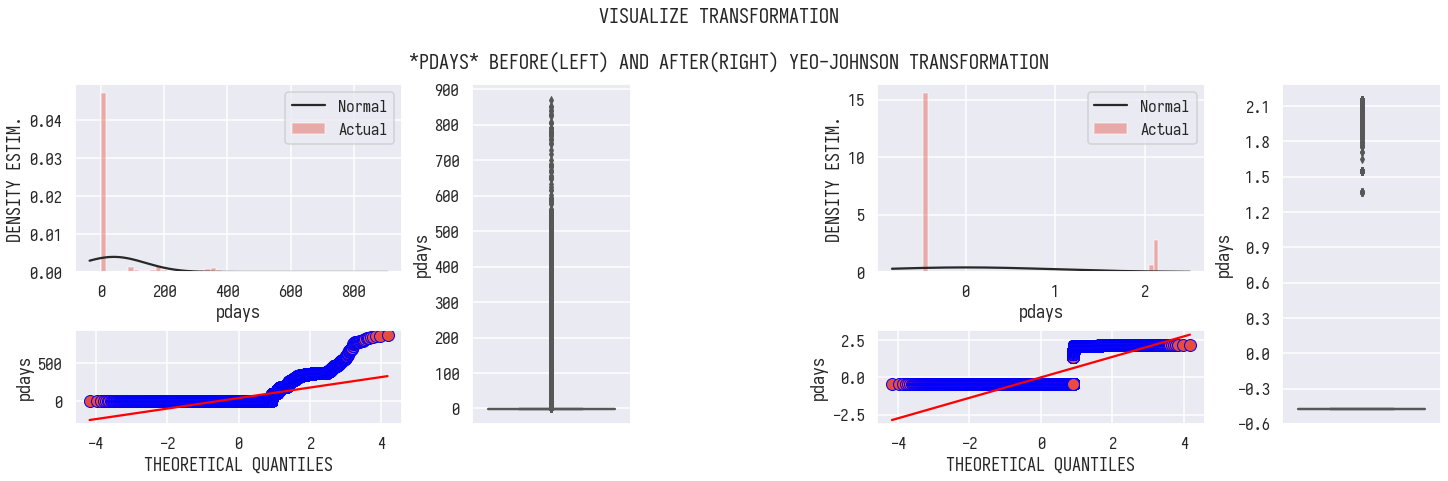

In [27]:
cols = ['age', 'day', 'balance', 'duration', 'campaign', 'pdays']
for col in cols: 
    plot_dist(dataset_enc, col, f'Visualize transformation \n\n *{col}* before(left) and after(right) yeo-johnson transformation'.upper(), PowerTransformer(method='yeo-johnson'))

In [28]:
# Yeo-Johnson transformation
def yeoj_transform(cols, X_fit=None, transformer=None):
    # If need to fit
    data = X_fit.copy()
    if not transformer:
        yeoj_transformer = PowerTransformer(method='yeo-johnson')
        data[cols] = yeoj_transformer.fit_transform(X_fit[cols])
        return data, yeoj_transformer
    else: 
        data[cols] = transformer.transform(X_fit[cols])
        return data

In [29]:
cols = ['age', 'day', 'balance', 'duration', 'campaign', 'pdays']
X_train_trans, yeoj_transformer = yeoj_transform(cols, X_fit=X_train_enc)
X_test_trans = yeoj_transform(cols, transformer=yeoj_transformer, X_fit=X_test_enc)

In [256]:
# Persist Transfomer  
def persist_yeoj_transformer():
    handler = open("flask-api/objects/yeoj_transformer.obj","wb")
    pickle.dump(yeoj_transformer, handler)
    handler.close()
# persist_yeoj_transformer()

### 2.3. Dataset Summary

In [30]:
X_train_trans.head(3)
print(f"X_Train: {X_train_trans.shape} - y_train: {y_train.shape}")
print(f"X_Test: {X_test_trans.shape} - y_test: {y_test.shape}")

,age,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,x0_Rare,x0_admin.,x0_blue-collar,x0_management,x0_retired,x0_services,x0_technician,x1_divorced,x1_married,x1_single
0,-0.3536,2,1,-0.0416,0,0,0.2011,1.4704,-0.0765,-0.3030,0.1345,-0.4716,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
1,-2.0305,2,1,1.0265,0,0,0.2737,-1.3521,0.6066,1.9513,1.0919,2.1264,1,0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,0.4348,2,1,-0.2975,1,0,0.2737,-0.3758,-0.0765,2.8766,1.0919,-0.4716,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000


X_Train: (36168, 24) - y_train: (36168,)
X_Test: (9043, 24) - y_test: (9043,)


In [314]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb                       # Usdf to tranform the dataset into DMatrix
from xgboost import plot_importance         # Used for plotting feature importance 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, 
                             classification_report, confusion_matrix, precision_recall_curve)
from sklearn.utils import compute_sample_weight
from sklearn.pipeline import Pipeline

## 3. Modelling 

### 3.1. Model Selection 
#### + Note:
- The performance metric we are referring to for this case study is ROC-AUC score while monitoring Precision, Recall, F1-score, and Accuracy beside. This is preferred over the other metrics as the dataset we are working with is an imbalanced dataset with the class `no` being in high proportion. Although ROC graphs are widely used to evaluate classifiers under presence of class imbalance, it has a drawback: under class rarity, that is, when the problem of class imbalance is associated to the presence of a low sample size of minority instances, as the estimates can be unreliable. For this reason we are closely taking care of the the Precision-Recall trade-off.  
- The first step is to carry out the model selection to filter only the best or near the classifiers. With that, we narrow down the time spent while performing hyperparameters tuning as we retain few classifiers.
- By having the best models we can further tuning their hyperparameters.
- We are considering to evaluate the following 10 estimators: 
    - LogisticRegression
    - KNeighborsClassifier
    - SGDClassifier
    - SVC
    - BaggingClassifier with KNeighborsClassifier sets as the weak classifier 
    - DecisionTreeClassifier
    - RandomForestClassifier
    - ExtraTreesClassifier
    - XGBClassifier
    - LGBMClassifier

In [93]:
# Generate class weights to balance the target labels proportion 
def generate_sample_weights(y_train):
    """This will help us to create balanced sample weight used as parameter of 
        XGBoost classifier for imbalanced dataset 
    """
    largest_class_weight_coef = max(y_train.value_counts().values) / y_train.shape[0]
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    weights = class_samples.sum() / (len(class_samples) * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    
    return sample_weights

# Compute weights 
sample_weights = pd.DataFrame(generate_sample_weights(y_train))

In [345]:
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),
    'SGDClassifier': SGDClassifier(loss="log", class_weight='balanced', random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(), 
    'SVC': SVC(probability=True, class_weight='balanced', random_state=42),
    'BaggingClassifier' : BaggingClassifier(base_estimator=SGDClassifier(class_weight='balanced', random_state=42, n_jobs=-1, max_iter=1500), oob_score=True, max_samples=0.5, max_features=1.0),
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf=0.01, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'ExtraTreesClassifier': ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBClassifier': XGBClassifier(random_state=42, n_jobs=-1),
    'LGBMClassifier': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
}

In [346]:
def get_scores(y_test, y_pred, y_pred_proba):
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return pre, rec, f1, acc, roc_auc

In [347]:
def make_cv(models, X, y):
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = pd.DataFrame()
    
    for i, (name, model) in enumerate(models.items()):
        ls_scores = list()
        
        for train_idx, test_idx in cv_folds.split(X, y):
            if name == 'XGBClassifier':
                model.fit(X.iloc[train_idx], y.iloc[train_idx], sample_weight=sample_weights.iloc[train_idx])
            else:
                model.fit(X.iloc[train_idx], y.iloc[train_idx])
            y_pred = model.predict(X.iloc[test_idx])
            y_pred_proba = model.predict_proba(X.iloc[test_idx])[:,1]
            ls_scores.append(get_scores(y.iloc[test_idx], y_pred, y_pred_proba))
            
        scores = np.array(ls_scores).mean(axis=0)
        cv_scores.loc[i, "Model"] = name
        cv_scores.loc[i, "Precision"] = scores[0]
        cv_scores.loc[i, "Recall"] = scores[1]
        cv_scores.loc[i, "F1-score"] = scores[2]
        cv_scores.loc[i, "Accuracy"] = scores[3]
        cv_scores.loc[i, "AUC-score"] = scores[4]
        
    return cv_scores
        

In [348]:
score_table = make_cv(models, X_train_trans, y_train)

In [349]:
score_table

,Model,Precision,Recall,F1-score,Accuracy,AUC-score
0,LogisticRegression,0.3697,0.8317,0.5119,0.8144,0.9004
1,SGDClassifier,0.3693,0.8161,0.5070,0.8135,0.8967
2,KNeighborsClassifier,0.5695,0.2848,0.3797,0.8911,0.8177
3,SVC,0.3692,0.8759,0.5195,0.8104,0.9106
4,BaggingClassifier,0.3735,0.8244,0.5137,0.8172,0.8828
5,DecisionTreeClassifier,0.3426,0.8681,0.4912,0.7896,0.9003
6,RandomForestClassifier,0.6727,0.3089,0.4232,0.9016,0.9255
7,ExtraTreesClassifier,0.6480,0.2862,0.3970,0.8983,0.9085
8,XGBClassifier,0.4894,0.7970,0.6063,0.8789,0.9265
9,LGBMClassifier,0.4412,0.8693,0.5853,0.8558,0.9318


#### + Observations:
- This table reveals that though the tree-based classifiers are not that good estimators by referring to the ROC-AUC score, they are performing better on the Precision score. That is useful as we want to reduce False Positive Rate in the way we should not label customers who did not subscribe a term deposit while they are not interested in making deposit. For this reason we will hold back the following models: 
    - LogisticRegression
    - RandomForestClassifier
    - XGBClassifier
    - LGBMClassifier

### 3.2. Model hyper-parameters tuning and reporting
We will carry out GridSearchCV to cap the hyperparameters within a pre-defined vector space. 
#### + Observations:
- We notice that `XGBClassifier` has achieved the better performance of `ROC_AUC = 92.91%` on the test set. However, the difference in `ROC_AUC` on the test set is not that significant for the 3 tree-based classifiers which are `RandomForestClassifier`, `XGBClassifier`, and `LGBMClassifier` that are `92.09%`, `92.91%`, and `92.80%`, respectively.
- Given that the performance is almost the same, the time complexity to train the hyperparameters for `XGBClassifier` is very high which is `6.9 hours` against `52 min` for `RandomForestClassifier` and  `3.2 hours` for `LGBMClassifier`. This evinced the high complexity of the model. 
- However in-class Macro Average Precision is higher for `XGBClassifier` as compared to the others. This score has to be considered as we are dealing with an imbalanced dataset.

In [146]:
# Set pipeline for each variable 
pipe_clf_logreg = Pipeline([('logreg', LogisticRegression(class_weight='balanced', random_state=42, max_iter=500, n_jobs=-1))])
pipe_clf_rf = Pipeline([('rf', RandomForestClassifier(class_weight='balanced', random_state=42, oob_score=True, n_jobs=-1))])
pipe_clf_xgb = Pipeline([('xgb', XGBClassifier(random_state=42, n_jobs=-1))])
pipe_clf_lgbm = Pipeline([('lgbm', LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])


# Set parameters for Grid Search
g_param_logreg = [{
    'logreg__penalty': ['l2'],
    'logreg__C': np.logspace(-4, 4, 20),
    'logreg__solver': ['sag']
}]
g_param_rf = [{
    'rf__criterion': ['entropy'],
    'rf__max_depth': [2, 4, 6, 10, 13, 15],
    'rf__min_samples_split': [3, 5],
    'rf__n_estimators' : [20, 70, 100, 200],
    'rf__max_features' : list(range(6,32,5))
}]
g_param_xgb = [{
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.5, 0.7],
    'xgb__colsample_bytree': [0.5, 0.7],
    'xgb__n_estimators' : [100, 200, 500],
    'xgb__objective': ['binary:logistic'],
    'xgb__tree_method': ['approx', 'auto']   
}]
g_param_lgbm = [{
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__num_leaves': [8, 32, 128], 
    'lgbm__min_child_weight': [1e-5, 1e-3, 1e-1, 1, 1e4],
    'lgbm__subsample': [0.5, 0.7], 
    'lgbm__reg_alpha': [0, 1e-1, 2, 7, 10, 50, 100],
    'lgbm__reg_lambda': [0, 1e-1, 1, 5, 10, 20]
}]


# Init. GridSearch  
cv_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_logreg = GridSearchCV(pipe_clf_logreg, param_grid=g_param_logreg, scoring='accuracy', cv=cv_skf) 
gs_rf = GridSearchCV(pipe_clf_rf, param_grid=g_param_rf, scoring='accuracy', cv=cv_skf) 
gs_xgb = GridSearchCV(pipe_clf_xgb, param_grid=g_param_xgb, scoring='accuracy', cv=cv_skf) 
gs_lgbm = GridSearchCV(pipe_clf_lgbm, param_grid=g_param_lgbm, scoring='accuracy', cv=cv_skf) 

In [150]:
############## ONLY RUN THIS CELL IN CASE YOU NEED TO TRAIN AND FINE TUNE THE MODELS #################
gs_models = {
    "LogisticRegression": gs_logreg,
    "RandomForestClassifier": gs_rf,
    "XGBClassifier": gs_xgb,
    "LGBMClassifier": gs_lgbm
}

result_acc = {}
result_auc = {}
models = []

for index, (name, model) in enumerate(gs_models.items()):
    start = time.time()
    print()
    print('+++++++ Start New Model ++++++++++++++++++++++')
    print(f'Estimator is {name}')
    model.fit(X_train_trans, y_train)
    print('---------------------------------------------')
    print('best params {}'.format(model.best_params_))
    print('best score is {}'.format(model.best_score_))
    auc = roc_auc_score(y_test, model.predict_proba(X_test_trans)[:,1])
    print('---------------------------------------------')
    print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test_trans, y_test)))
    end = time.time()
    print('It lasted for {} sec'.format(round(end - start, 3)))
    print('++++++++ End Model +++++++++++++++++++++++++++')
    print()
    print()
    models.append(model.best_estimator_)
    result_acc[index] = model.best_score_
    result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is LogisticRegression


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500,
                                                           n_jobs=-1,
                                                           random_state=42))]),
             param_grid=[{'logreg__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['sag']}],
             scoring='accuracy')

---------------------------------------------
best params {'logreg__C': 1.623776739188721, 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}
best score is 0.8143385951733142
---------------------------------------------
ROC_AUC is 0.8978680489054974 and accuracy rate is 0.815547937631317
It lasted for 370.441 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForestClassifier


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               oob_score=True,
                                                               random_state=42))]),
             param_grid=[{'rf__criterion': ['entropy'],
                          'rf__max_depth': [2, 4, 6, 10, 13, 15],
                          'rf__max_features': [6, 11, 16, 21, 26, 31],
                          'rf__min_samples_split': [3, 5],
                          'rf__n_estimators': [20, 70, 100, 200]}],
             scoring='accuracy')

---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 15, 'rf__max_features': 11, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.8951008343819057
---------------------------------------------
ROC_AUC is 0.9209862419257279 and accuracy rate is 0.8938405396439235
It lasted for 3126.236 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is XGBClassifier


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                              

---------------------------------------------
best params {'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.7, 'xgb__tree_method': 'auto'}
best score is 0.908869896028788
---------------------------------------------
ROC_AUC is 0.9291305886628165 and accuracy rate is 0.9081057171292712
It lasted for 25104.232 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is LGBMClassifier


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       random_state=42))]),
             param_grid=[{'lgbm__max_depth': [3, 5, 7],
                          'lgbm__min_child_weight': [1e-05, 0.001, 0.01, 0.1, 1,
                                                     100.0, 10000.0],
                          'lgbm__num_leaves': [8, 32, 128],
                          'lgbm__reg_alpha': [0, 0.1, 2, 7, 10, 50, 100],
                          'lgbm__reg_lambda': [0, 0.1, 1, 5, 10, 20],
                          'lgbm__subsample': [0.5, 0.7]}],
             scoring='accuracy')

---------------------------------------------
best params {'lgbm__max_depth': 7, 'lgbm__min_child_weight': 1, 'lgbm__num_leaves': 128, 'lgbm__reg_alpha': 0.1, 'lgbm__reg_lambda': 0, 'lgbm__subsample': 0.5}
best score is 0.863995776125315
---------------------------------------------
ROC_AUC is 0.9280926074764474 and accuracy rate is 0.8595598805706071
It lasted for 11652.88 sec
++++++++ End Model +++++++++++++++++++++++++++




=========== Estimator : LogisticRegression ===========

+ CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      7985
           1       0.37      0.83      0.51      1058

    accuracy                           0.82      9043
   macro avg       0.67      0.82      0.70      9043
weighted avg       0.90      0.82      0.84      9043


+ CONFUSION MATRIX


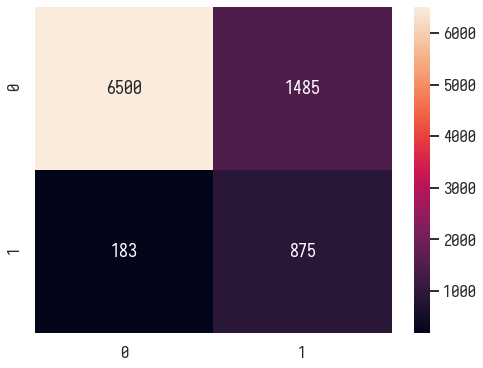


=========== Estimator : RandomForestClassifier ===========

+ CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7985
           1       0.54      0.69      0.60      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.80      0.77      9043
weighted avg       0.91      0.89      0.90      9043


+ CONFUSION MATRIX


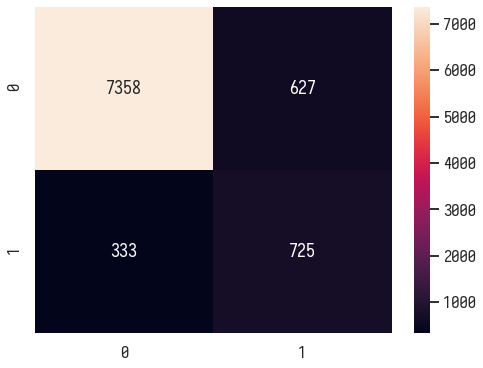


=========== Estimator : XGBClassifier ===========

+ CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.44      0.53      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.70      0.74      9043
weighted avg       0.90      0.91      0.90      9043


+ CONFUSION MATRIX


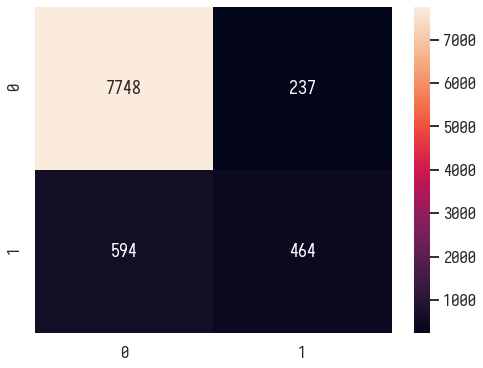


=========== Estimator : LGBMClassifier ===========

+ CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7985
           1       0.45      0.86      0.59      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.86      0.75      9043
weighted avg       0.92      0.86      0.88      9043


+ CONFUSION MATRIX


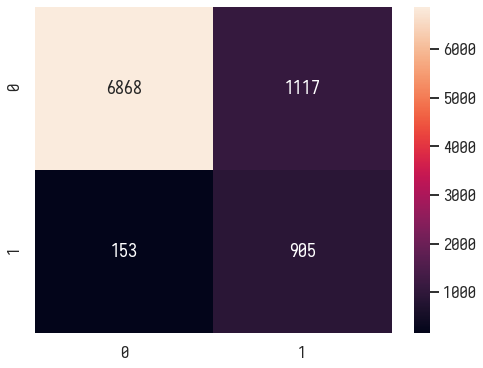

In [200]:
def vis_clf_report(models, X_test, y_test): 
    for (name, _), model in zip(gs_models.items(), models):
        y_pred = model.predict(X_test)
        print(f"=========== Estimator : {name} ===========\n")
        print(f"+ Classification Report".upper())
        clf_report = classification_report(y_test, y_pred)
        print(f"{clf_report}\n")
        clf_confmatrix = confusion_matrix(y_test, y_pred)
        print(f"+ Confusion Matrix".upper())
        plt.figure(figsize=(8,6))
        sns.heatmap(clf_confmatrix, fmt=".0f", annot=True)
        plt.show()
        print()
        
vis_clf_report(models, X_test_trans, y_test)

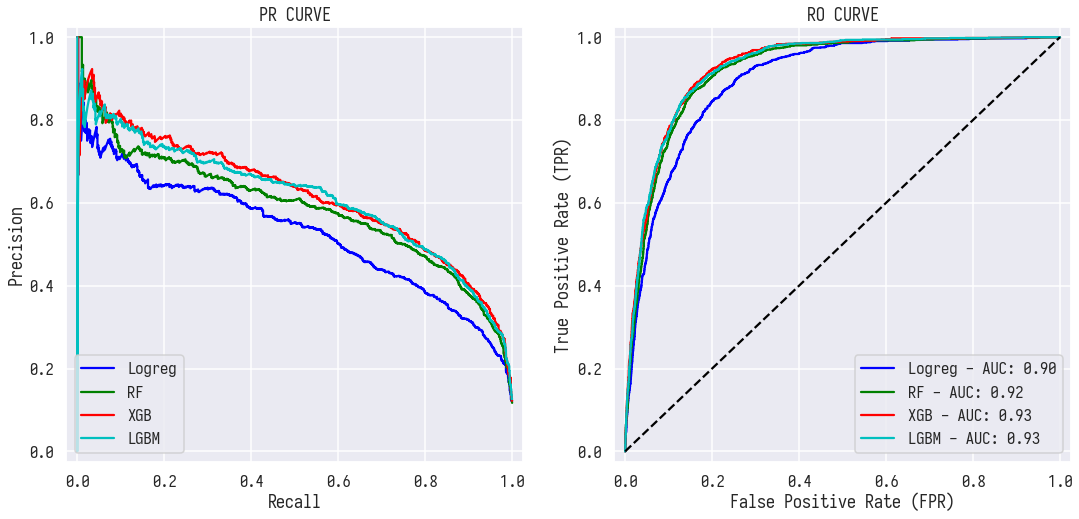

In [287]:
def vis_clf_performance(models, X_test, y_test): 
    # setup the figure
    fig = plt.figure(figsize=(18,8))

    # plot one for PR curve
    pr_ax = fig.add_subplot(1,2,1)
    pr_ax.set_xlim([-0.025,1.025])
    pr_ax.set_ylim([-0.025,1.025])
    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_title('PR CURVE')

    # plot 2 for ROC curve
    roc_ax = fig.add_subplot(1,2,2)
    roc_ax.set_xlim([-0.025,1.025])
    roc_ax.set_ylim([-0.025,1.025])
    roc_ax.set_xlabel('False Positive Rate (FPR)')
    roc_ax.set_ylabel('True Positive Rate (TPR)')
    roc_ax.set_title('RO CURVE')
    
    labels = ["Logreg","RF","XGB","LGBM"]
    for model, color, label in zip(models, 'bgrc', labels):
        
        y_pred_prob = model.predict_proba(X_test)[:,1]
        
        auc = roc_auc_score(y_test, y_pred_prob)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        pr, rc, _ = precision_recall_curve(y_test, y_pred_prob)
        
        pr_ax.plot(rc, pr, c=color, label=f'{label}')
        roc_ax.plot(fpr, tpr, c=color, label=f'{label} - AUC: {auc:.2f}')
        
    # plot the baseline ROC curve     
    roc_ax.plot([0,1], [0,1], 'k--')
    
    pr_ax.legend(loc='lower left')    
    roc_ax.legend(loc='lower right')
    plt.show()

vis_clf_performance(models, X_test_trans, y_test)

In [355]:
# Fit and persist model 
def fit_model(X_train, y_train, X_test, y_test):
    clf_logreg = LogisticRegression(C=1.623776739188721,
                                class_weight='balanced', 
                                max_iter=500,
                                n_jobs=-1, 
                                random_state=42, 
                                solver='sag')
    
    clf_rf = RandomForestClassifier(class_weight='balanced', 
                                criterion='entropy', 
                                max_depth=15, 
                                max_features=11, 
                                min_samples_split=3, 
                                n_estimators=70, 
                                n_jobs=-1, 
                                oob_score=True, 
                                random_state=42)
    
    clf_xgb = XGBClassifier(colsample_bytree=0.5, learning_rate=0.1,
                            max_depth=5, min_child_weight=1,
                            n_estimators=200, objective='binary:logistic', 
                            subsample=0.7, method='auto')
    
    clf_lgbm = LGBMClassifier(class_weight='balanced', max_depth=7,
                                 min_child_weight=1, num_leaves=128,
                                 random_state=42, reg_alpha=0.1, reg_lambda=0,
                                 subsample=0.5)
    
    # Fit XGB
    clf_xgb.fit(X_train, y_train, eval_metric='auc')
    y_pred = clf_xgb.predict(X_test)
    y_pred_proba = clf_xgb.predict_proba(X_test)[:,1]
    
    # TO-DO 
    # - Fit other classifiers 
    
    # Evaluate on Test set 
    pre, rec, f1, acc, roc_auc = get_scores(y_test, y_pred, y_pred_proba)
    print("Model performance after training using the best parameters(Test): ")
    
    score = pd.DataFrame(np.array([["XGBClassifier", pre, rec, f1, acc, roc_auc]]), 
                         columns=["Model", "Precision", "Recall", "F1-score", "Accuracy", "ROC-AUC"])
    display(score)
    
    # Persist model 
    joblib.dump(clf_xgb, "flask-api/objects/clf_xgb_final.model")
    
    return clf_xgb

model = fit_model(X_train_trans, y_train, X_test_trans, y_test)

[21:02:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model performance after training using the best parameters(Test): 


,Model,Precision,Recall,F1-score,Accuracy,ROC-AUC
0,XGBClassifier,0.6467315716272601,0.43950850661625707,0.5233539673607204,0.9063363927900033,0.9271326317184986


In [358]:
def plot_feat_importance(model, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    _ = plot_importance(booster=model, ax=ax, **kwargs)
    plt.show()

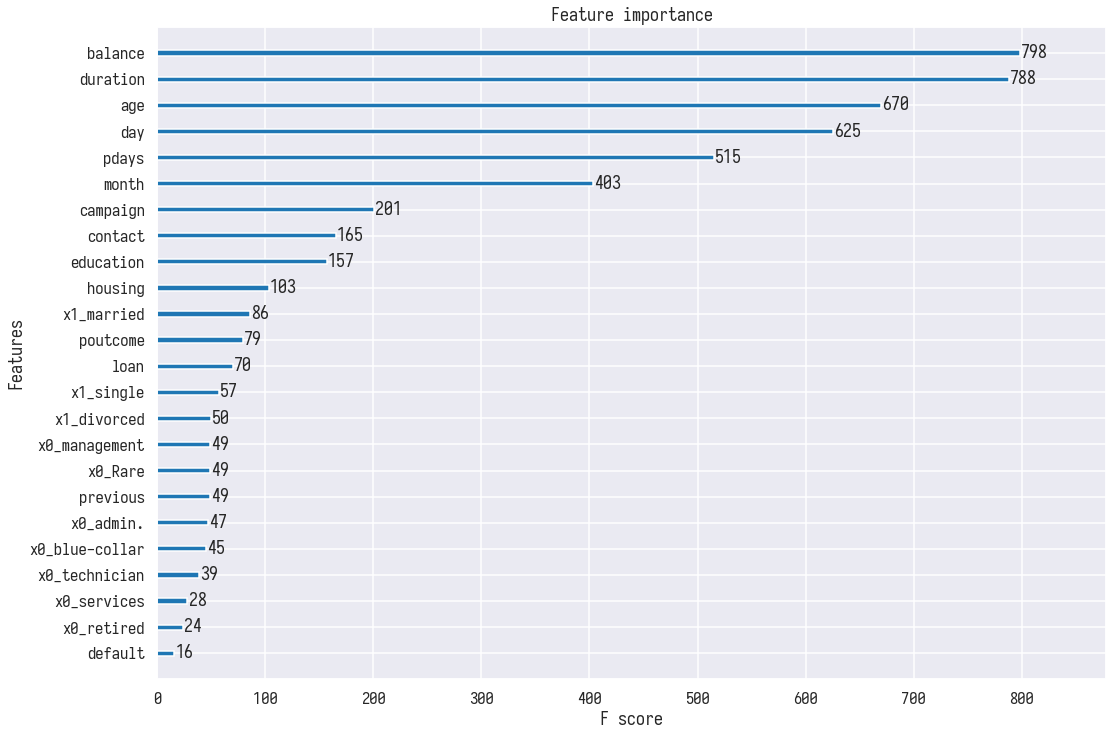

In [359]:
model = joblib.load("flask-api/objects/clf_xgb_final.model")
plot_feat_importance(model, (17, 12))

## 4. Model generalization and improvement perspective 
Due to time constraints, we provided narrowed data analysis in the above detail. Though there are several perspectives that one can approach to further improve the model generalization and effectiveness.

For that, we can consider: 

- Features re-engineering. In that, one can approach the following perspective:  
    - the use of different **categorical encoders** other than the proposed in our analysis. For instance, using **TargetEncoder**, **FrequencyEncoder**, and so on...  
    - **capping outliers** using statistical approaches such as **IQR** or **Z-score**
    - **select relevant features** using statistical Hypothesis Testing. For instance, as we are dealing with a lot of categorical features and given that the target is also categorical, one can consider the use of **Chi-Square Test** for testing the feature dependencies.   
- The use of a more generalized model that considers the power of strong learners. For instance, **Voting** or **Stacking classifiers**, etc...  
- **Fine tune** the optimal and reasonable **class weights** as we are only laid on the inbuilt weight computation provided by sklearn.  
- **Fine tune** the optimal features using feature importance score.
- Setting an **optimal prediction probability threshold**.
- **Fine tune** the hyper parameters using some optimal parameter tuners technique such **Bayesian optimization** like *Hyperopt*, *Optuna*, etc... Approaching **AutoML** may also be helpful.   


In [361]:
# Export Libs 

xgboost==1.1.1
seaborn==0.10.1
scipy==1.5.0
scikit-learn==0.23.2
pandas==1.1.0
numpy==1.19.1
matplotlib==3.3.1
lightgbm==2.3.0
joblib==0.16.0
